<a href="https://colab.research.google.com/github/farhan0167/Object-Dectection/blob/main/Inference-BEITDETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 11.8 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 6.6 MB 49.5 MB/s 


( vocab_size = 8192hidden_size = 768num_hidden_layers = 12num_attention_heads = 12intermediate_size = 3072hidden_act = 'gelu'hidden_dropout_prob = 0.0attention_probs_dropout_prob = 0.0initializer_range = 0.02layer_norm_eps = 1e-12is_encoder_decoder = Falseimage_size = 224patch_size = 16num_channels = 3use_mask_token = Falseuse_absolute_position_embeddings = Falseuse_relative_position_bias = Falseuse_shared_relative_position_bias = Falselayer_scale_init_value = 0.1drop_path_rate = 0.1use_mean_pooling = Trueout_indices = [3, 5, 7, 11]pool_scales = [1, 2, 3, 6]use_auxiliary_head = Trueauxiliary_loss_weight = 0.4auxiliary_channels = 256auxiliary_num_convs = 1auxiliary_concat_input = Falsesemantic_loss_ignore_index = 255**kwargs )

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import torch

#BEIT

In [ ]:
from transformers import BeitModel, BeitConfig,BeitFeatureExtractor, BeitForImageClassification

"""# Initializing a BEiT beit-base-patch16-224-pt22k style configuration
configuration = BeitConfig(hidden_size=256, num_attention_heads=8)

# Initializing a model from the beit-base-patch16-224-pt22k style configuration
#feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
model = BeitModel(configuration).from_pretrained("microsoft/beit-base-patch16-224-pt22k")

# Accessing the model configuration
configuration = model.config
configuration"""

'# Initializing a BEiT beit-base-patch16-224-pt22k style configuration\nconfiguration = BeitConfig(hidden_size=256, num_attention_heads=8)\n\n# Initializing a model from the beit-base-patch16-224-pt22k style configuration\n#feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")\nmodel = BeitModel(configuration).from_pretrained("microsoft/beit-base-patch16-224-pt22k")\n\n# Accessing the model configuration\nconfiguration = model.config\nconfiguration'

## To access the Repository

In order to access my files, I have shared a google [drive](https://drive.google.com/drive/folders/1xh0DK0IgdCQqOWVY39mRjsqcnnlO2gox?usp=sharing) folder. Make a copy of this in your own drive. Mount your drive and go to the folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/mightydetr/detr

## DETR 

In [ ]:
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [ ]:
class DETR(nn.Module):
    def __init__(self, num_classes, hidden_dim=768, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()
        self.beit = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
        #self.beit = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224')
        # create conversion layer
        self.conv = nn.Conv2d(3, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)
        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
    
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))



    def forward(self, pixel_values):
        #print("image shape=",pixel_values.shape)
        #h = pixel_values
        h = self.beit(pixel_values).last_hidden_state
        h = h[0][1:].unsqueeze(0)
        #print("Output of beit [batch_size, seq_len, hidden_size]=",h.shape)
        # convert from 3 to 256 feature planes for the transformer
        #h = self.conv(pixel_values)
        print("Output of conv layer [HxW, batch_size, hidden_dim]=", h.shape)

        # construct positional encodings

        

        print("(0.1 * h.flatten(2).permute(2, 0, 1)).shape",(0.1 * h.flatten(2).permute(2, 0, 1)).shape)
        print("transformer input 1=",(h.transpose(0,1)).shape)
        print("transformer input 2=",self.query_pos.unsqueeze(1).shape )
        # propagate through the transformer
        h = self.transformer(h.transpose(0,1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        print(h.shape)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [ ]:
# COCO classes
"""CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]"""
CLASSES = [
     'face', 'N/A'
]


# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    #T.Resize((70,70)),
    T.Resize((224,224)),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform2 = T.ToPILImage()

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform):
    feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)
    #img2 = transform2(img)
    #the feature extractor essentially sets the image up for the way the beit wants its input. This is not the encoder.
    #img = feature_extractor(images=im, return_tensors="pt")#['pixel_values'].squeeze(1)
    

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    #assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > -4

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [47]:
%cd /content/drive/MyDrive/mightydetr/detr/outputs2

/content/drive/MyDrive/mightydetr/detr/outputs2


In [48]:
!ls

checkpoint0000.pth  checkpoint0004.pth	checkpoint0008.pth  log.txt
checkpoint0001.pth  checkpoint0005.pth	checkpoint0009.pth
checkpoint0002.pth  checkpoint0006.pth	checkpoint.pth
checkpoint0003.pth  checkpoint0007.pth	eval


In [ ]:
detr_beit = DETR(num_classes=2)
#state_dict = torch.load_state_dict(torch.load('checkpoint0007.pth'))
detr_beit.load_state_dict(torch.load('checkpoint0009.pth', map_location=torch.device('cpu')), strict=False)
detr_beit.eval();

Some weights of the model checkpoint at microsoft/beit-base-patch16-224-pt22k were not used when initializing BeitModel: ['lm_head.bias', 'lm_head.weight', 'layernorm.bias', 'layernorm.weight']
- This IS expected if you are initializing BeitModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.weight', 'beit.pooler.layernorm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from PIL import Image
import requests
url = 'https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F20%2F2022%2F02%2F11%2Fdonald-trump-3.jpg&q=60'
im = Image.open(requests.get(url, stream=True).raw)


In [ ]:
scores, boxes = detect(im, detr_beit, transform)

Output of conv layer [HxW, batch_size, hidden_dim]= torch.Size([1, 196, 768])
(0.1 * h.flatten(2).permute(2, 0, 1)).shape torch.Size([768, 1, 196])
transformer input 1= torch.Size([196, 1, 768])
transformer input 2= torch.Size([100, 1, 768])
torch.Size([1, 100, 768])


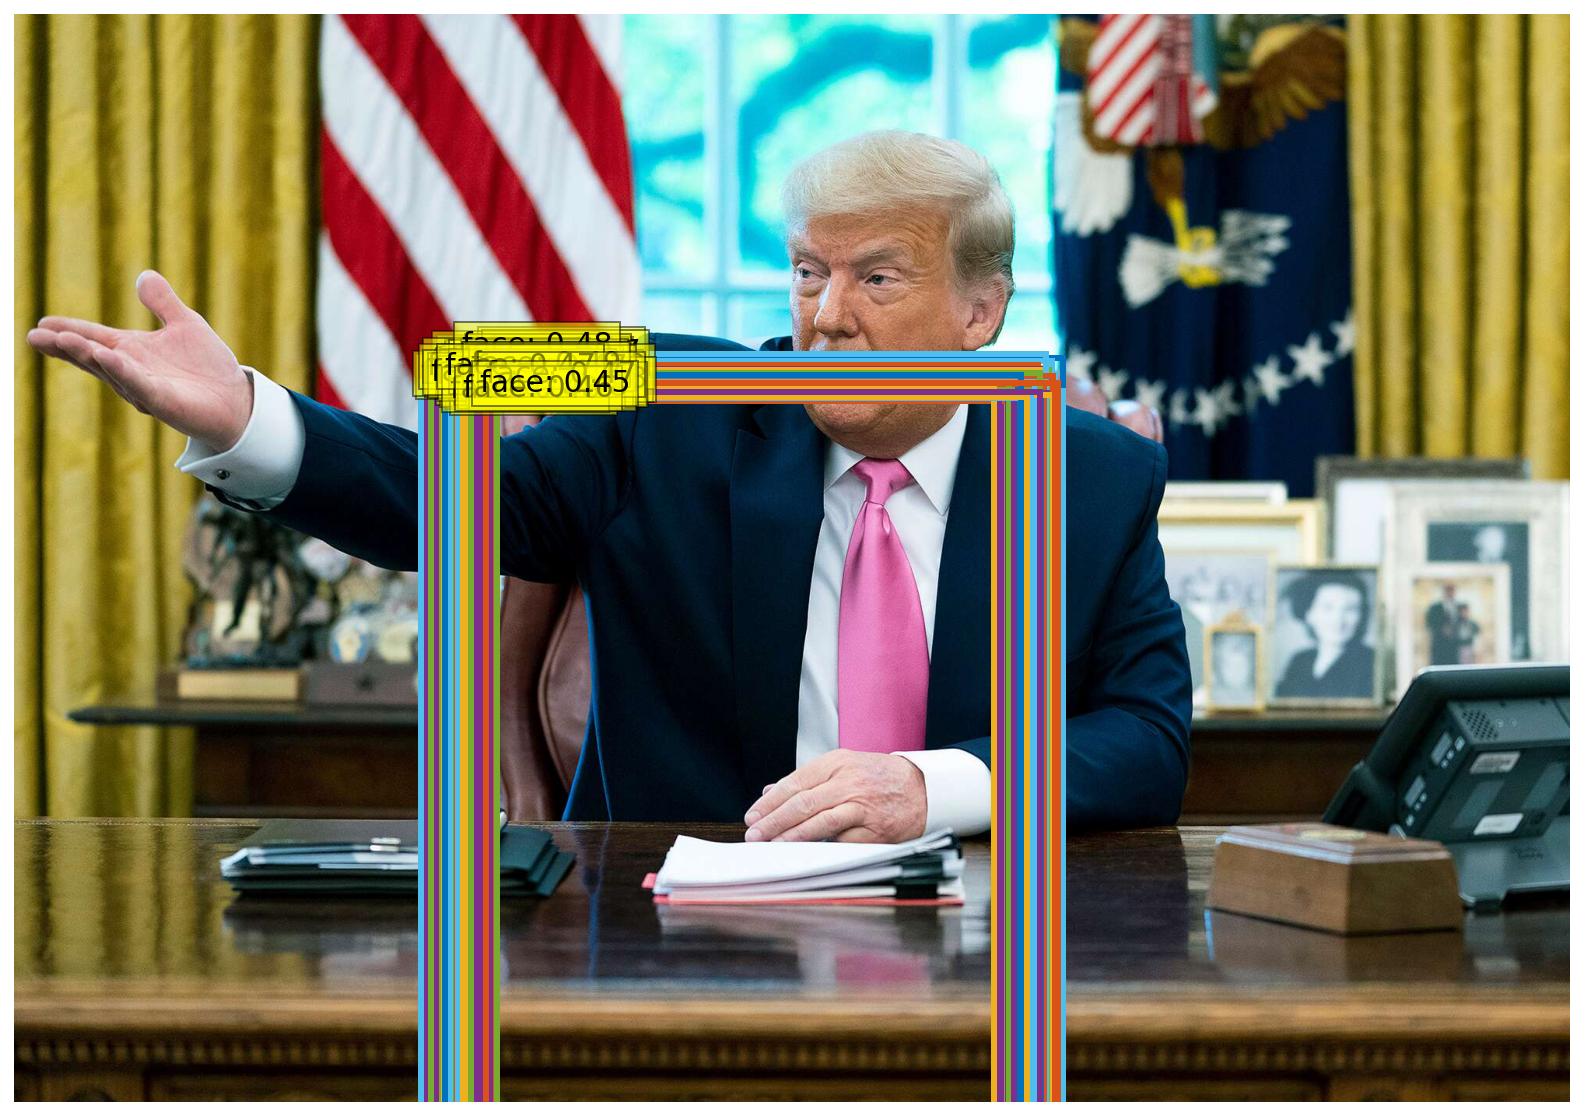

In [ ]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(im, scores, boxes)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')